In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from glob import glob

import scipy.stats as stats
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [35]:
dir_plots = './plots/'
dir_file = './data/sharew8_all/'
rel_data_dir_easy = './data/sharew8_easy/'

all_files = glob(f"{dir_file}*.dta")
easy_files = glob(f"{rel_data_dir_easy}*.dta")

df_easy = pd.read_stata(easy_files[0])
df_easy = df_easy[df_easy['wave'] == 8]
df_acc_day = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_gv_accelerometer_day.dta'))
df_ph = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_ph.dta'))
df_br = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_br.dta'))


In [36]:
df1 = df_acc_day[["mergeid", "measurementday", "GGIR_mean_ENMO_day", "GGIR_N_valid_hours_day", "OxCGRT_stay_at_home", "OxCGRT_stringency_index"]].copy()
df1 = df1.drop(df1.loc[df1['measurementday'] > 7].index)
df1 = df1.drop(df1.loc[df1['GGIR_N_valid_hours_day'] < 16].index)
df2 = df_ph[["mergeid", 'ph006d2', 'ph006d5', 'ph006d20', 'ph087d2', 'ph087d3']].copy()
df3 = df_br[["mergeid", 'br015_', 'br016_']].copy()
df4 = df_easy[["mergeid", "female", "age", "bmi"]].copy()

In [37]:
def get_common_columns(df1, df2, merge_on=['mergeid']):
    common = df1.columns.difference(df2.columns).tolist()
    common.extend(merge_on)
    return common

In [38]:
df = df1.copy()
df = pd.merge(left=df, left_on=['mergeid'], right=df2[get_common_columns(df2, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df3[get_common_columns(df3, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df4[get_common_columns(df4, df)], right_on=['mergeid'], how='left')

In [39]:
def map_selected_num(df, columns:list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].map({
            'Selected': 1,
            'Not selected': 0,
            "Don't know": -1,
            'Refusal': -1,
            1:1,
            0:0,
            -1:-1,
        })
    return df
df = map_selected_num(df, ['ph006d2', 'ph006d5', 'ph006d20', 'ph087d2', 'ph087d3'])

def map_bmi_num(df, columns: list[str] = ['bmi']):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            '-15. no information': -1,
            '-13. not asked in this wave': -1,
            "-12. don't know / refusal": -1,
            '-3. implausible value/suspected wrong': -1,
        })
        df[c] = df[c].astype(float)
    return df
df = map_bmi_num(df)
df = df.drop(df.loc[df['bmi'] < 15].index)

def map_freq_num(df, columns:list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            'More than once a week': 1,
            'Once a week': 2,
            'One to three times a month': 3,
            'Hardly ever, or never': 4,
            "Don't know": -1,
            'Refusal' : -1,
        })
        df[c] = df[c].astype(float)
    return df
df = map_freq_num(df, ['br015_', 'br016_']) 

df['female'] = pd.to_numeric(df['female'].replace({'1. female': 1, '0. male': 0}))
df.loc[:, 'age'] = df.replace({'-15. no information': -1})
df.loc[:, 'age'] = df['age'].astype(float)

In [40]:
df['Hypertension'] = pd.to_numeric(df['ph006d2'])
df['Diabetes'] = pd.to_numeric(df['ph006d5'])
df['OA'] = np.where(((df['ph006d20'] == 1) & (df['ph087d2'] == 1)) | ((df['ph006d20'] == 1) & (df['ph087d3'] == 1)), int(1), int(0))

In [41]:
df['d1'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 0) & (df['OA'] == 0), int(1), int(0))
df['d2'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 1) & (df['OA'] == 0), int(1), int(0))
df['d3'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 0) & (df['OA'] == 1), int(1), int(0))
df['d4'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 1) & (df['OA'] == 0), int(1), int(0))
df['d5'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 0) & (df['OA'] == 1), int(1), int(0))
df['d6'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 1) & (df['OA'] == 1), int(1), int(0))
df['d7'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 1) & (df['OA'] == 1), int(1), int(0))
df['control'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 0) & (df['OA'] == 0), int(1), int(0))
df['disease']  = df[['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'control',]].apply(lambda x: x.idxmax(), axis=1)

In [42]:
df[['Hypertension', 'Diabetes', 'OA']].value_counts() # check, that d group assoc still works

Hypertension  Diabetes  OA
0             0         0     2503
1             0         0     1587
              1         0      433
0             0         1      316
              1         0      297
1             0         1      297
              1         1      110
0             1         1       36
dtype: int64

In [43]:
df[['d1' ,'control']].value_counts() # check for target groups

d1  control
0   1          2503
1   0          1587
0   0          1489
dtype: int64

In [44]:
groups = ["d1", "d2", "d3", "d4", "d5", "d6", "d7"]
categorie = [1,0,-1]

for g in groups:
    conditions = [
        (df[g] == 1) & (df['control'] == 0),
        (df['control'] == 1),
        (df[g] == 0) & (df['control'] == 0)
    ]
    df[f'{g}_strict'] = np.select(conditions,categorie,default=0)

In [45]:
df[['d1_strict', 'control']].value_counts() # identical to target groups -> works

d1_strict  control
 0         1          2503
 1         0          1587
-1         0          1489
dtype: int64

run d1_strict: dropped 1489 of 5579 samples (73.3%)
run d2_strict: dropped 2779 of 5579 samples (50.2%)
run d3_strict: dropped 2760 of 5579 samples (50.5%)
run d4_strict: dropped 2643 of 5579 samples (52.6%)
run d5_strict: dropped 2779 of 5579 samples (50.2%)
run d6_strict: dropped 3040 of 5579 samples (45.5%)
run d7_strict: dropped 2966 of 5579 samples (46.8%)


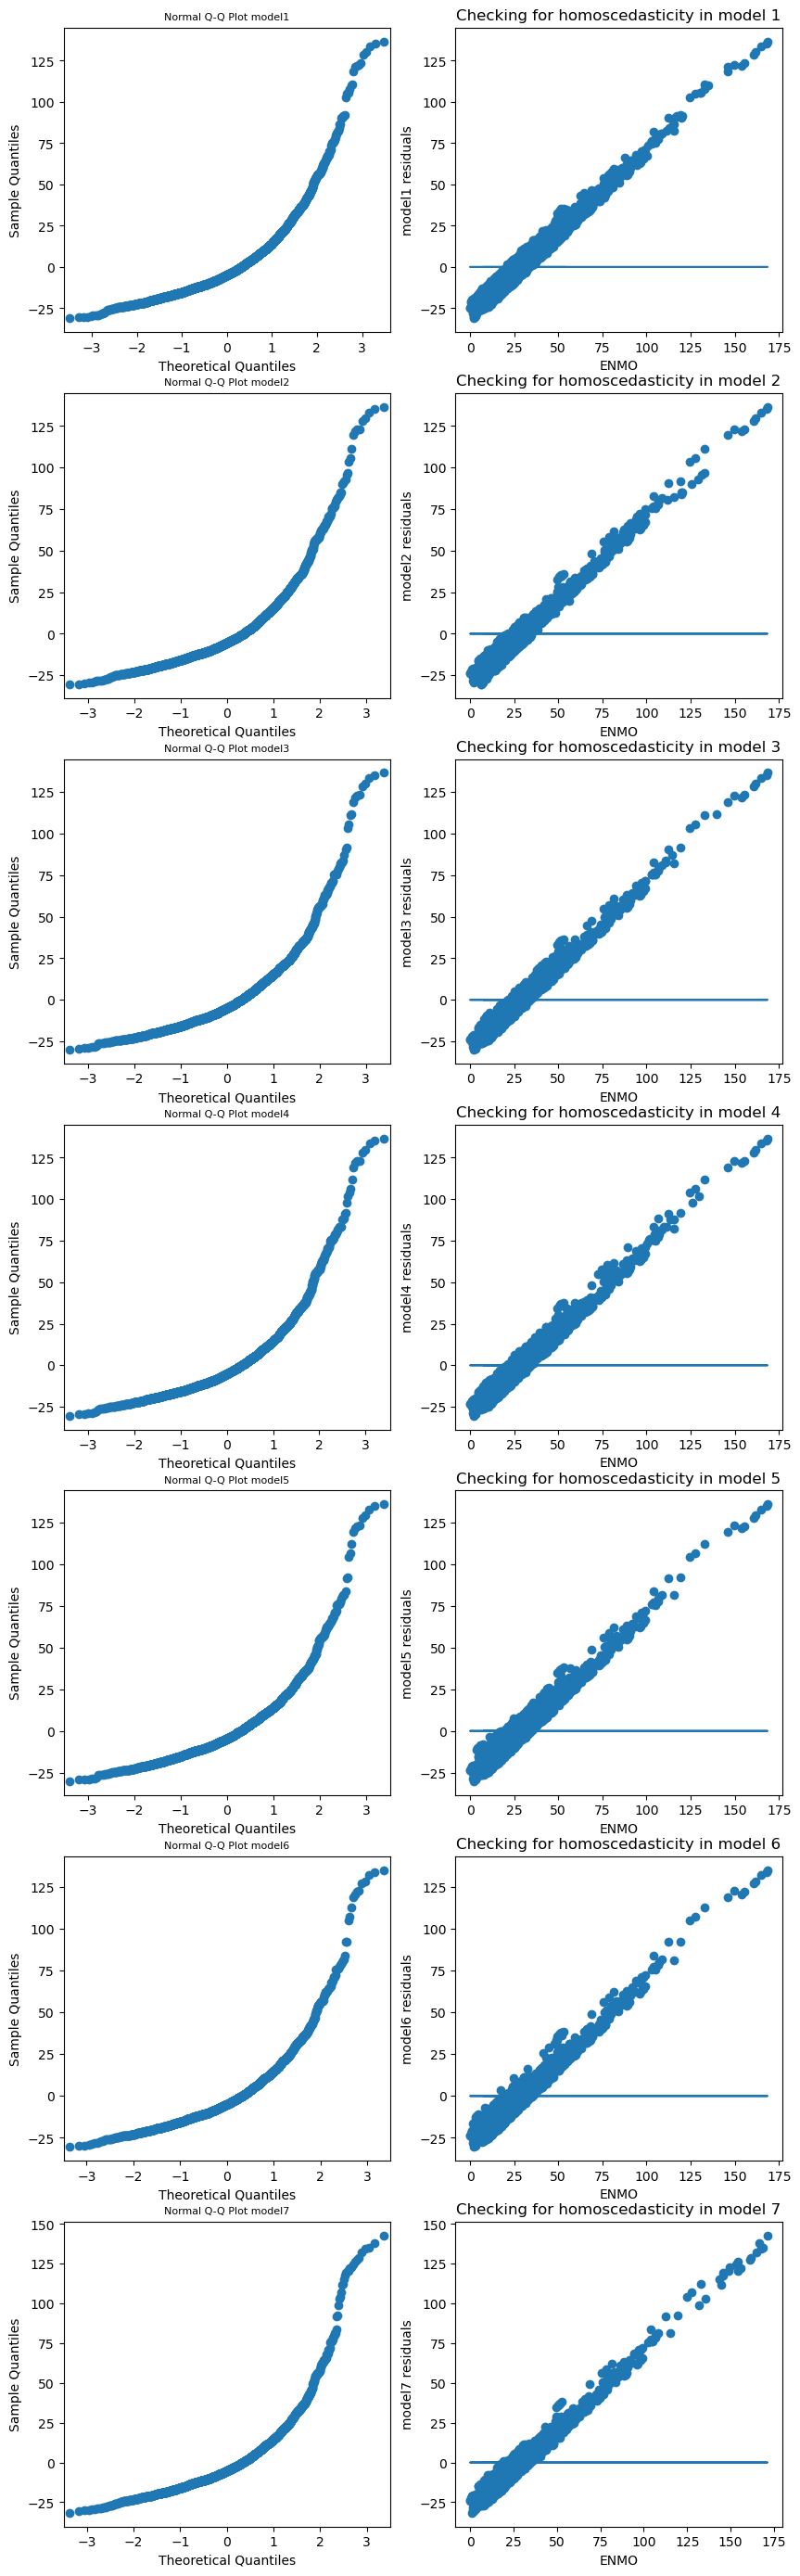

In [46]:
fig, ax = plt.subplots(7,2, figsize=(10,35))
result = pd.DataFrame()
models = []
vif = []

for i, g in enumerate(groups):
    g = f'{g}_strict'
    _df = df.drop(df.loc[df[g] == -1].index)
    
    # print # of dropped samples -> should match -1 samples from above. does -> works
    print(f'run {g}: dropped {len(df)- len(_df)} of {len(df)} samples ({len(_df)/len(df):.1%})') 
    
    _YVar = _df["GGIR_mean_ENMO_day"] #dependent

    _XVar = _df[[g, "measurementday", "age", "female", "bmi"]] #independent
    _XVar1 = sm.add_constant(_XVar)
    _model = sm.OLS(_YVar, _XVar1).fit()
    #_models = models.append(_model)
    as_html =_model.summary(slim=True).tables[1].as_html() 
    res = pd.read_html(as_html, header=0, index_col=0)[0]

    residuals = _model.resid
    sm.qqplot(residuals, ax=ax[i,0])
    ax[i,0].set_title(f"Normal Q-Q Plot model{i+1}",fontsize=8)

    ax[i,1].scatter(_YVar,residuals)
    ax[i,1].set_xlabel("ENMO")
    ax[i,1].set_ylabel(f"model{i+1} residuals")
    ax[i,1].set_title(f"Checking for homoscedasticity in model {i+1}")
    ax[i,1].plot(_YVar, [0]*len(_YVar))

    _vif = pd.DataFrame()
    _vif["VIF Factor"] = [variance_inflation_factor(_XVar1.values, i) for i in range(_XVar1.shape[1])]
    _vif["features"] = _XVar1.columns
    _vif.round(1)
    vif.append(_vif)

    result = pd.concat([result, res])
vif = pd.concat(vif)


In [47]:
result.reset_index().groupby(by='index').mean() # mean performance across regressions

,coef,std err,t,P>|t|,[0.025,0.975]
index,,,,,,
age,-0.369614,0.044429,-8.331857,0.000000,-0.456857,-0.282571
bmi,-0.235900,0.090429,-2.692571,0.041286,-0.413143,-0.058714
const,60.955143,4.250714,14.463857,0.000000,52.620429,69.290000
d1_strict,0.125700,0.664000,0.189000,0.850000,-1.175000,1.427000
d2_strict,3.726400,1.294000,2.879000,0.004000,1.188000,6.264000
d3_strict,0.402600,1.196000,0.337000,0.736000,-1.942000,2.748000
d4_strict,-1.182900,1.122000,-1.055000,0.292000,-3.382000,1.016000
d5_strict,-2.694600,1.232000,-2.186000,0.029000,-5.111000,-0.278000
d6_strict,-8.699600,3.318000,-2.622000,0.009000,-15.205000,-2.194000


In [48]:
result.reset_index().groupby(by='index').var() # check var to make sure constants are stable (age, bmi, ..) -> they are

,coef,std err,t,P>|t|,[0.025,0.975]
index,,,,,,
age,0.001281,0.000022,0.318086,0.000000,0.001872,0.000867
bmi,0.005097,0.000110,1.054479,0.003185,0.003894,0.007161
const,6.520789,0.184819,2.321266,0.000000,5.770968,8.692401
d1_strict,NaN,NaN,NaN,NaN,NaN,NaN
d2_strict,NaN,NaN,NaN,NaN,NaN,NaN
d3_strict,NaN,NaN,NaN,NaN,NaN,NaN
d4_strict,NaN,NaN,NaN,NaN,NaN,NaN
d5_strict,NaN,NaN,NaN,NaN,NaN,NaN
d6_strict,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
#result.reset_index().groupby(by='index').mean().to_excel("results.xlsx")

Linearity

In [50]:
from matplotlib import cm
def qqplot(x, y,palette= cm.viridis, ax=None, *args, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    sns.scatterplot(x=xr, y=yr, ax=ax, edgecolor="none", palette=palette, *args, **kwargs)

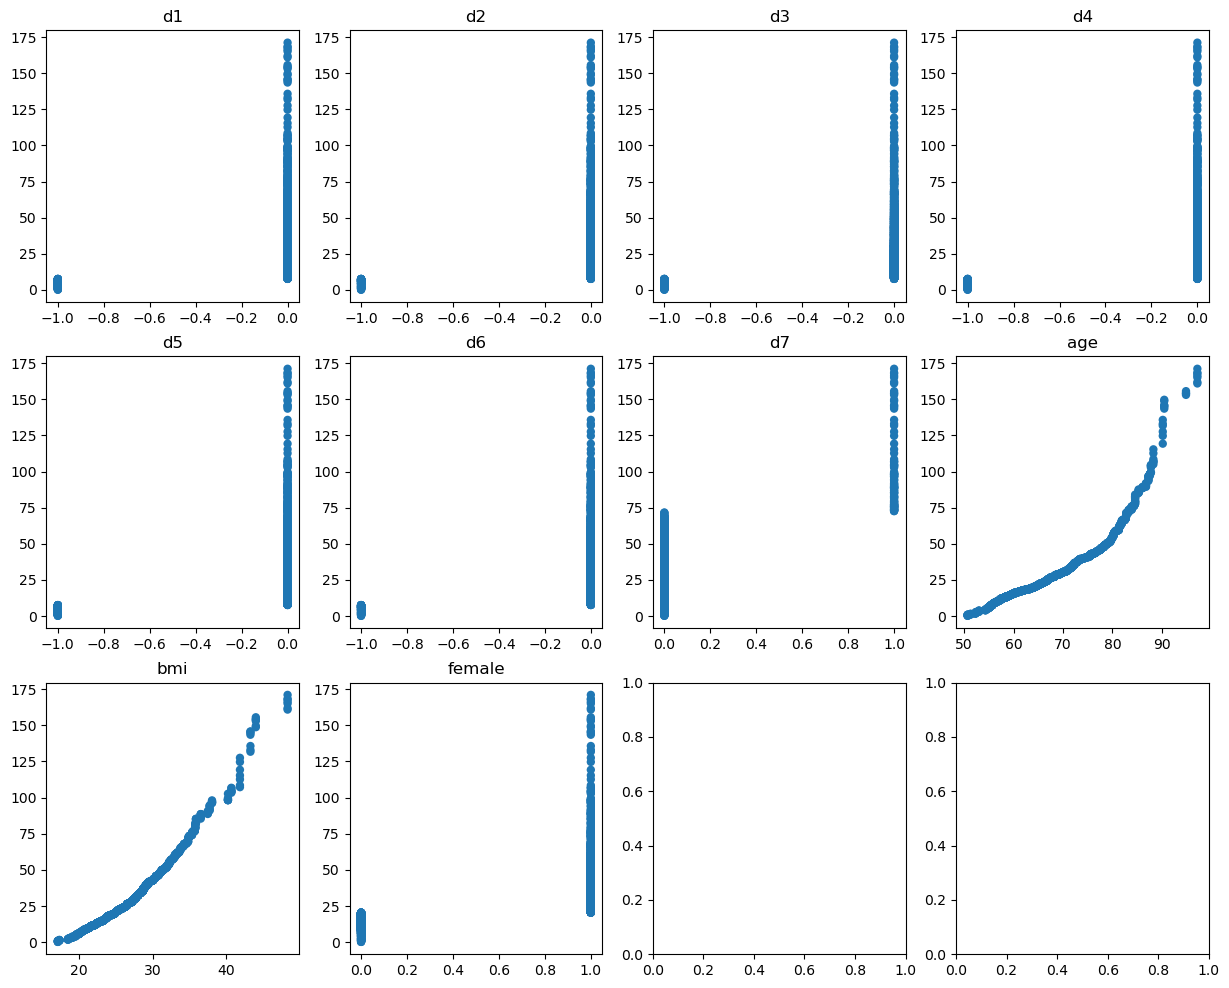

In [51]:
fig, ax = plt.subplots(3, 4, figsize=(15,12))
qqplot(_df['d1_strict'],_df["GGIR_mean_ENMO_day"], ax=ax[0,0])
ax[0,0].set_title("d1")
qqplot(_df['d2_strict'],_df["GGIR_mean_ENMO_day"], ax=ax[0,1])
ax[0,1].set_title("d2")
qqplot(_df['d3_strict'],_df["GGIR_mean_ENMO_day"], ax=ax[0,2])
ax[0,2].set_title("d3")
qqplot(_df['d4_strict'],_df["GGIR_mean_ENMO_day"], ax=ax[0,3])
ax[0,3].set_title("d4")
qqplot(_df['d5_strict'],_df["GGIR_mean_ENMO_day"], ax=ax[1,0])
ax[1,0].set_title("d5")
qqplot(_df['d6_strict'],_df["GGIR_mean_ENMO_day"], ax=ax[1,1])
ax[1,1].set_title("d6")
qqplot(_df['d7_strict'],_df["GGIR_mean_ENMO_day"], ax=ax[1,2])
ax[1,2].set_title("d7")
qqplot(_df["age"],_df["GGIR_mean_ENMO_day"], ax=ax[1,3])
ax[1,3].set_title("age")
qqplot(_df['bmi'],_df["GGIR_mean_ENMO_day"], ax=ax[2,0])
ax[2,0].set_title("bmi")
qqplot(_df['female'],_df["GGIR_mean_ENMO_day"], ax=ax[2,1])
ax[2,1].set_title("female")
plt.savefig(f'{dir_plots} Linear Assumtion')

1) Normality of the residuals (should follow normal distribution)

    -> slightly S-formed, might indicate the relationships are not actually linear.

2) Homoscedasticity (Error is constant along the dependent variable)

NameError: name 'model_dict' is not defined

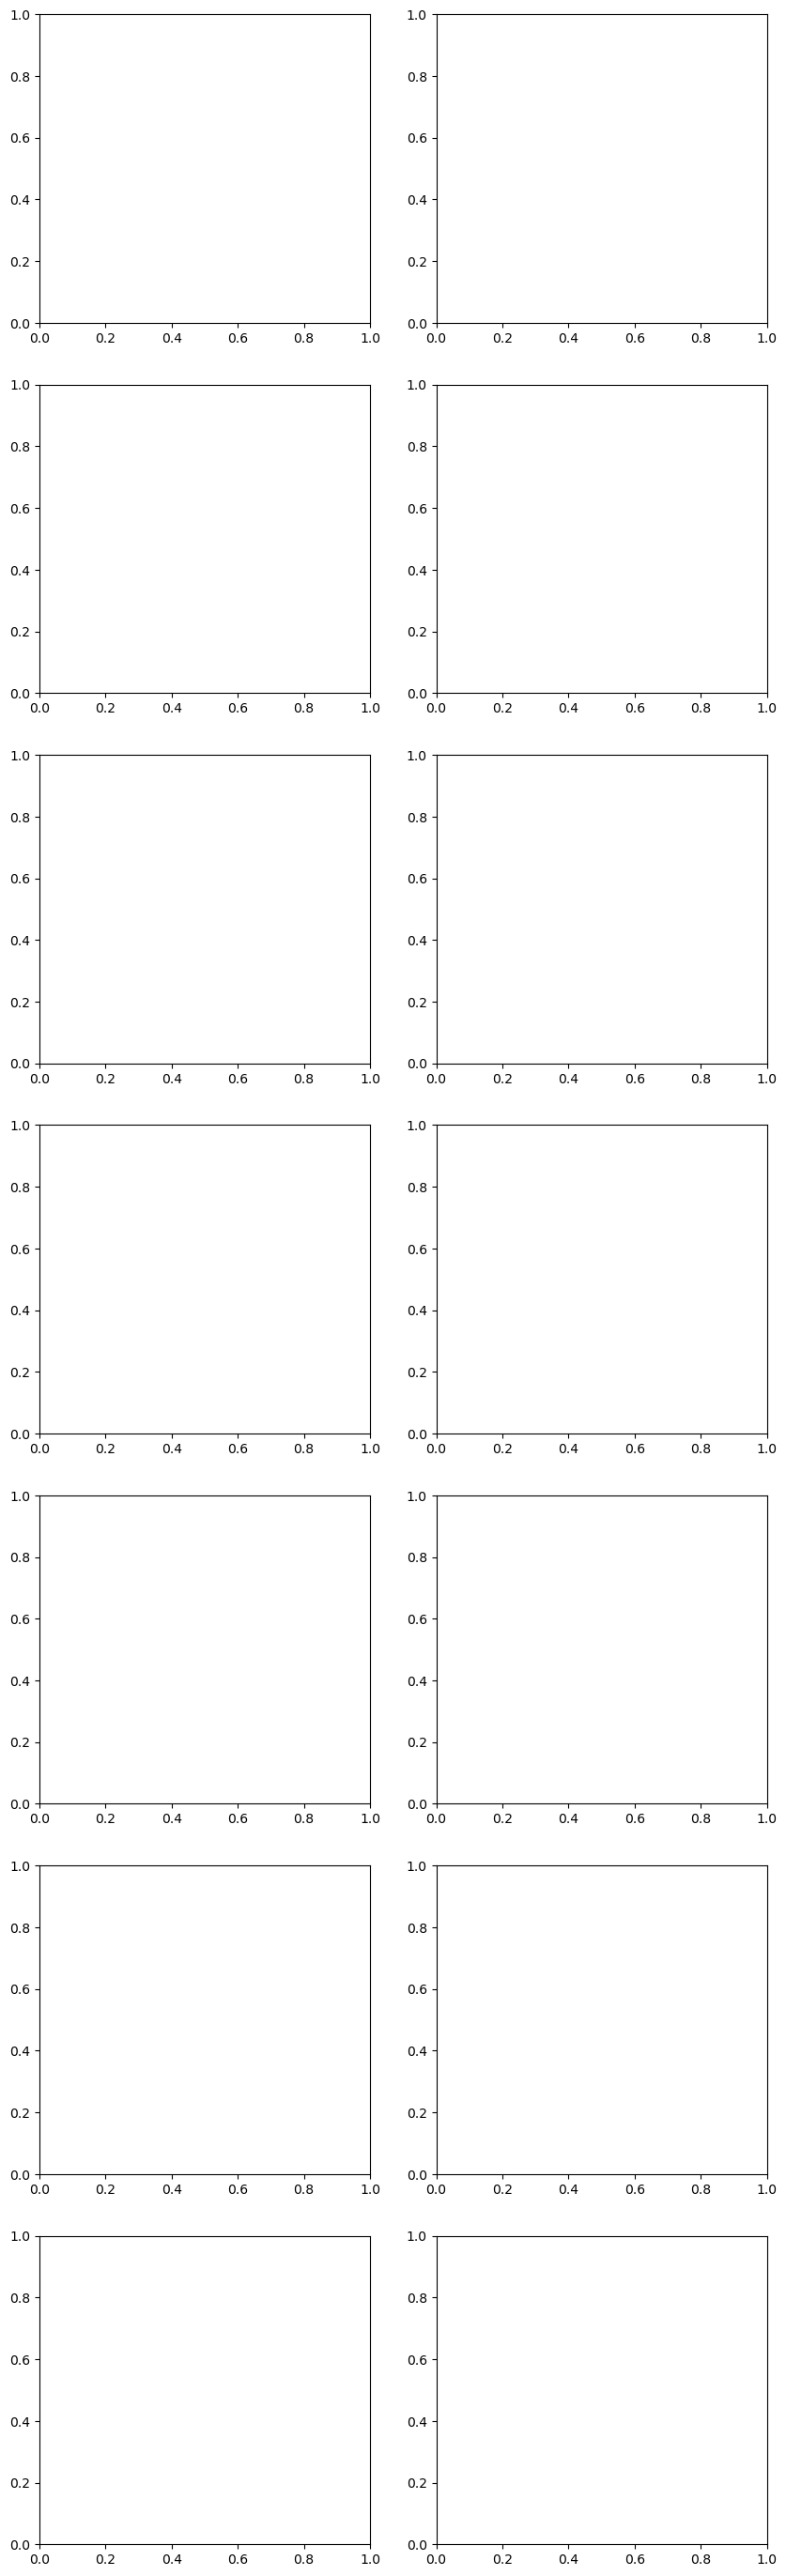

In [52]:
fig, ax = plt.subplots(7,2, figsize=(10,35))
for i, m in enumerate(model_dict):
    residuals = m.resid
    sm.qqplot(residuals, ax=ax[i,0])
    ax[i,0].set_title(f"Normal Q-Q Plot model{i+1}",fontsize=8)

    ax[i,1].scatter(_df['GGIR_mean_ENMO_day'], residuals)
plt.show()

'''
    ax[i,1].set_xlabel("ENMO")
    ax[i,1].set_ylabel("model residuals")
    ax[i,1].set_title(f"Checking for homoscedasticity in model {i+1}")
    ax[i,1].plot(_df["GGIR_mean_ENMO_day"], [0]*len(_df["GGIR_mean_ENMO_day"]))
'''


'Older' version d1...d7

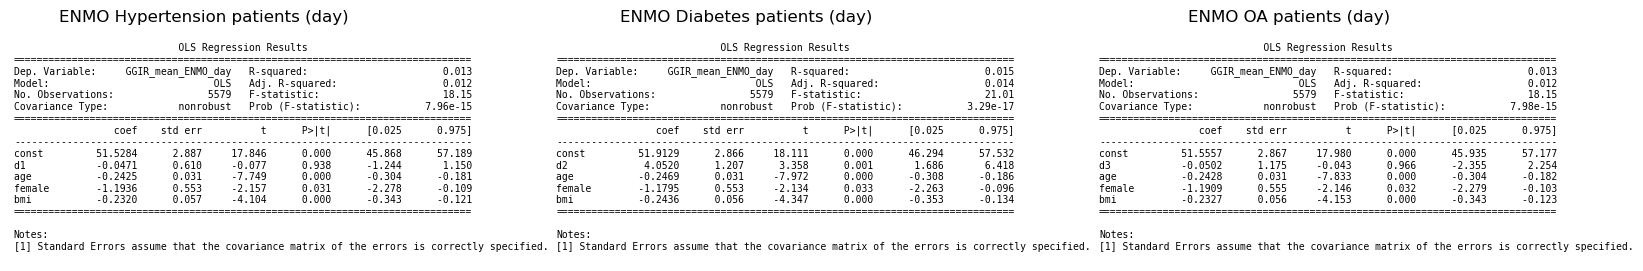

In [ ]:
group = ["Hypertension", "Diabetes", "OA"]

YVar = df["GGIR_mean_ENMO_day"]

XVar1 = df[["d1", "age", "female", "bmi"]]
XVar1 = sm.add_constant(XVar1)
models = [sm.OLS(YVar, XVar1).fit()]

XVar2 = df[["d2", "age", "female", "bmi"]]
XVar2 = sm.add_constant(XVar2)
models.append(sm.OLS(YVar, XVar2).fit())

XVar3 = df[["d3", "age", "female", "bmi"]]
XVar3 = sm.add_constant(XVar3)
models.append(sm.OLS(YVar, XVar3).fit())

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(19, 3))
for i in [0,1,2]:
    ax[i].text(0.01, 0.05, str(models[i].summary(slim=True)), {'fontsize': 7}, fontproperties = 'monospace')
    ax[i].set_title(f"ENMO {group[i]} patients (day)")
    ax[i].set_axis_off()
fig.subplots_adjust(wspace=.4) 
#plt.savefig(f'{dir_plots} Reg_ENMO_day (d1-d3)')

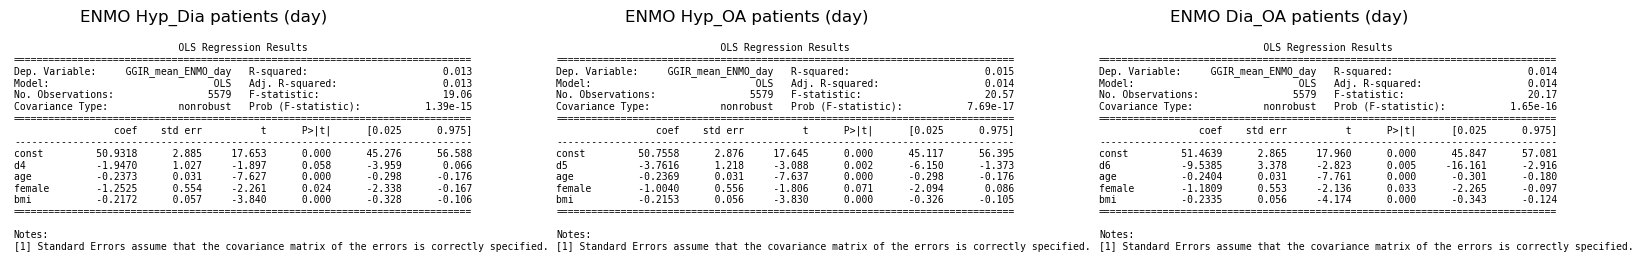

In [ ]:
group = ["Hyp_Dia", "Hyp_OA", "Dia_OA"]

XVar4 = df[["d4", "age", "female", "bmi"]]
XVar4 = sm.add_constant(XVar4)
models = [sm.OLS(YVar, XVar4).fit()]

XVar5 = df[["d5", "age", "female", "bmi"]]
XVar5 = sm.add_constant(XVar5)
models.append(sm.OLS(YVar, XVar5).fit())

XVar6 = df[["d6", "age", "female", "bmi"]]
XVar6 = sm.add_constant(XVar6)
models.append(sm.OLS(YVar, XVar6).fit())


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(19, 3))
for i in [0,1,2]:
    ax[i].text(0.01, 0.05, str(models[i].summary(slim=True)), {'fontsize': 7}, fontproperties = 'monospace')
    ax[i].set_title(f"ENMO {group[i]} patients (day)")
    ax[i].set_axis_off()
fig.subplots_adjust(wspace=.4)    
#plt.savefig(f'{dir_plots} Reg_ENMO_day (d4-d6)')

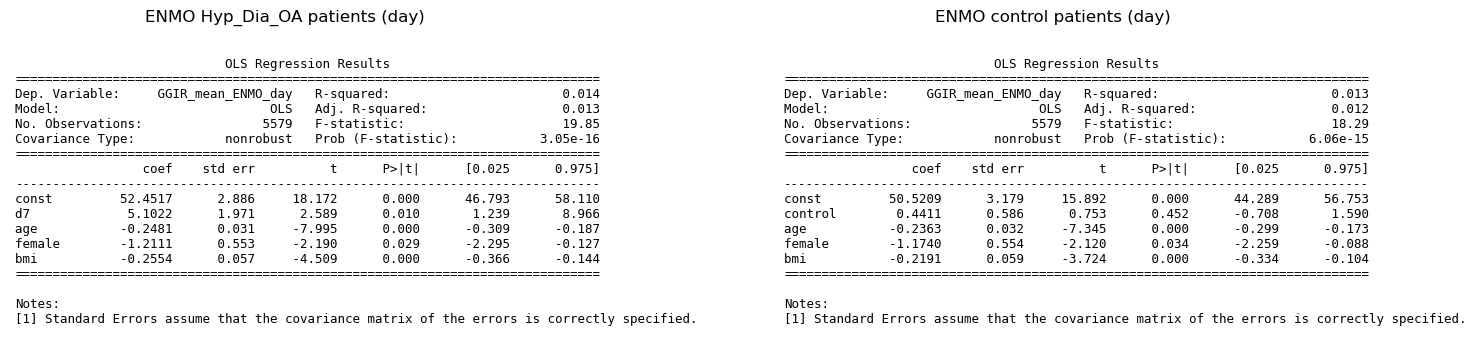

In [ ]:
group = ["Hyp_Dia_OA", "control"]

YVar = df["GGIR_mean_ENMO_day"]

XVar7 = df[["d7", "age", "female", "bmi"]]
XVar7 = sm.add_constant(XVar7)
models = [sm.OLS(YVar, XVar7).fit()]

XVar8 = df[["control", "age", "female", "bmi"]]
XVar8 = sm.add_constant(XVar8)
models.append(sm.OLS(YVar, XVar8).fit())


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 4))
for i in [0,1]:
    ax[i].text(0.01, 0.05, str(models[i].summary(slim=True)), {'fontsize': 9}, fontproperties = 'monospace')
    ax[i].set_title(f"ENMO {group[i]} patients (day)")
    ax[i].set_axis_off()
fig.subplots_adjust(wspace=.4)    
#plt.savefig(f'{dir_plots} Reg_ENMO_day (d7, control)')

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor1"] = [variance_inflation_factor(XVar1.values, i) for i in range(XVar1.shape[1])]
vif["features1"] = XVar1.columns
vif["VIF Factor2"] = [variance_inflation_factor(XVar2.values, i) for i in range(XVar2.shape[1])]
vif["features2"] = XVar2.columns
vif["VIF Factor3"] = [variance_inflation_factor(XVar3.values, i) for i in range(XVar3.shape[1])]
vif["features3"] = XVar3.columns
vif["VIF Factor4"] = [variance_inflation_factor(XVar4.values, i) for i in range(XVar4.shape[1])]
vif["features4"] = XVar4.columns
vif["VIF Factor5"] = [variance_inflation_factor(XVar5.values, i) for i in range(XVar5.shape[1])]
vif["features5"] = XVar5.columns
vif["VIF Factor6"] = [variance_inflation_factor(XVar6.values, i) for i in range(XVar6.shape[1])]
vif["features6"] = XVar6.columns
vif["VIF Factor7"] = [variance_inflation_factor(XVar7.values, i) for i in range(XVar7.shape[1])]
vif["features7"] = XVar7.columns
vif["VIF Factor8"] = [variance_inflation_factor(XVar8.values, i) for i in range(XVar8.shape[1])]
vif["features8"] = XVar8.columns
vif.round(1)

,VIF Factor1,features1,VIF Factor2,features2,VIF Factor3,features3,VIF Factor4,features4,VIF Factor5,features5,VIF Factor6,features6,VIF Factor7,features7,VIF Factor8,features8
0,113.9,const,112.5,const,112.3,const,113.8,const,113.2,const,112.3,const,113.9,const,138.1,const
1,1.0,d1,1.0,d2,1.0,d3,1.0,d4,1.0,d5,1.0,d6,1.0,d7,1.2,control
2,1.1,age,1.0,age,1.0,age,1.0,age,1.0,age,1.0,age,1.0,age,1.1,age
3,1.0,female,1.0,female,1.0,female,1.0,female,1.0,female,1.0,female,1.0,female,1.0,female
4,1.0,bmi,1.0,bmi,1.0,bmi,1.0,bmi,1.0,bmi,1.0,bmi,1.0,bmi,1.1,bmi


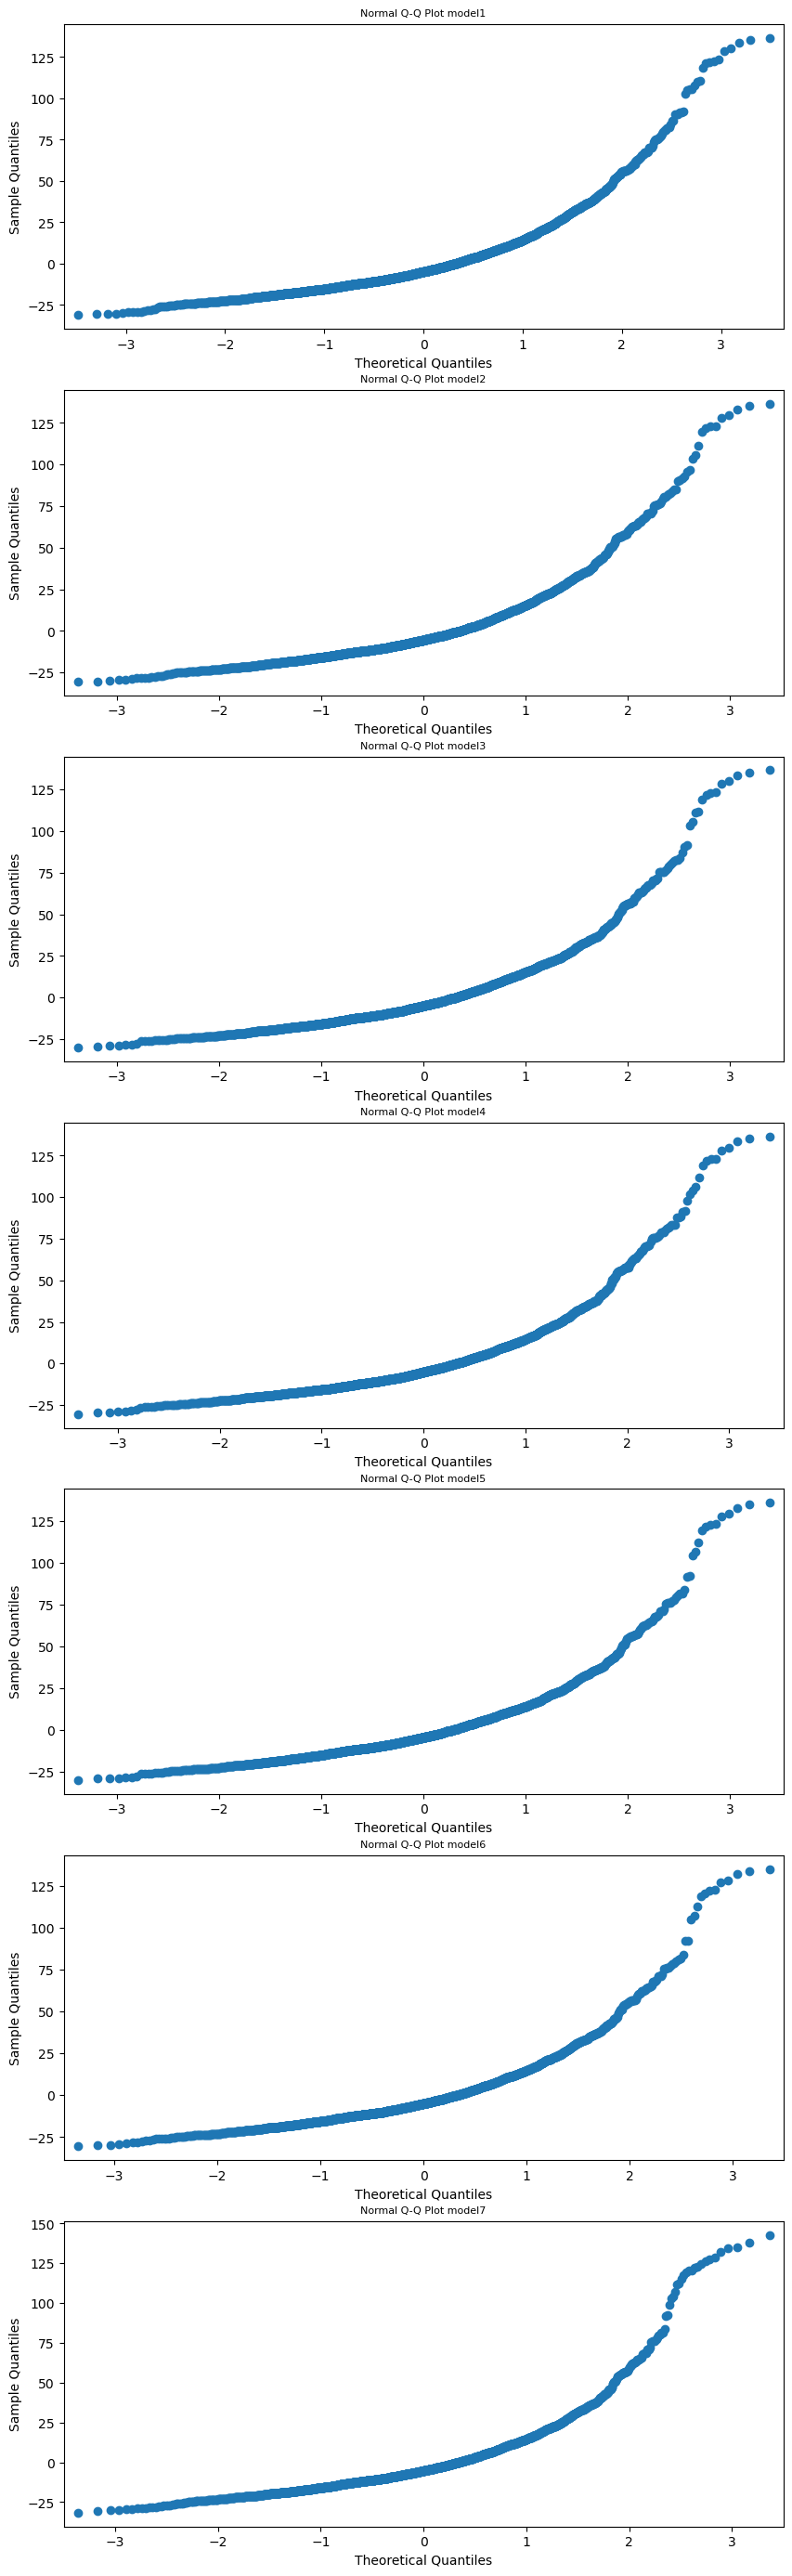

In [ ]:
'''
res = []
fig, ax = plt.subplots(7, figsize=(10,35))
for i, m in enumerate(model_dict):
    residuals = m.resid
    res.append(residuals)
    sm.qqplot(residuals, ax=ax[i])
    ax[i].set_title(f"Normal Q-Q Plot model{i+1}",fontsize=8)
plt.show()
'''

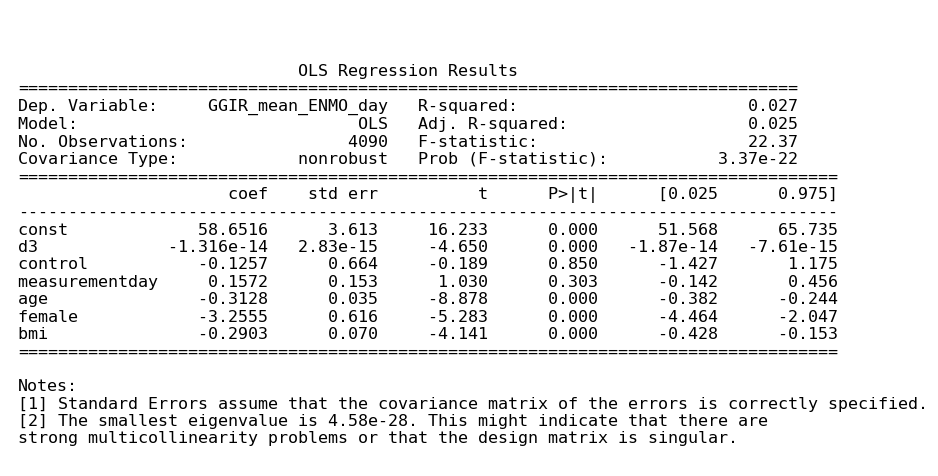

In [ ]:
XVar = df[["d3", "control", "measurementday", "age", "female", "bmi"]] #independent
XVar1 = sm.add_constant(XVar)
model = sm.OLS(YVar, XVar1).fit()
#print(model.summary(slim=True))

plt.rc('figure', figsize=(10, 5))
plt.text(0.01, 0.05, str(model.summary(slim=True)), {'fontsize': 12}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'{dir_plots} Regression ENMO day - Osteoarthritis')

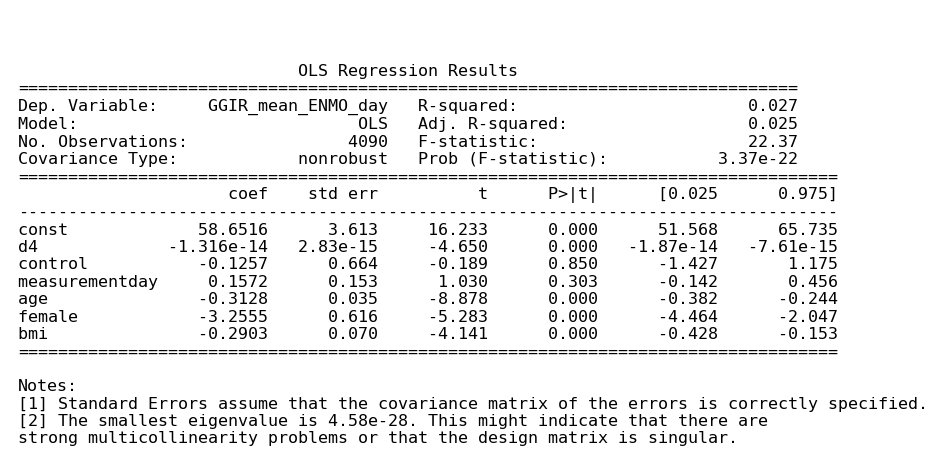

In [ ]:
XVar = df[["d4", "control", "measurementday", "age", "female", "bmi"]] #independent
XVar1 = sm.add_constant(XVar)
model = sm.OLS(YVar, XVar1).fit()
#print(model.summary(slim=True))

plt.rc('figure', figsize=(10, 5))
plt.text(0.01, 0.05, str(model.summary(slim=True)), {'fontsize': 12}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'{dir_plots} Regression ENMO day - Hypertension&Diabetes')

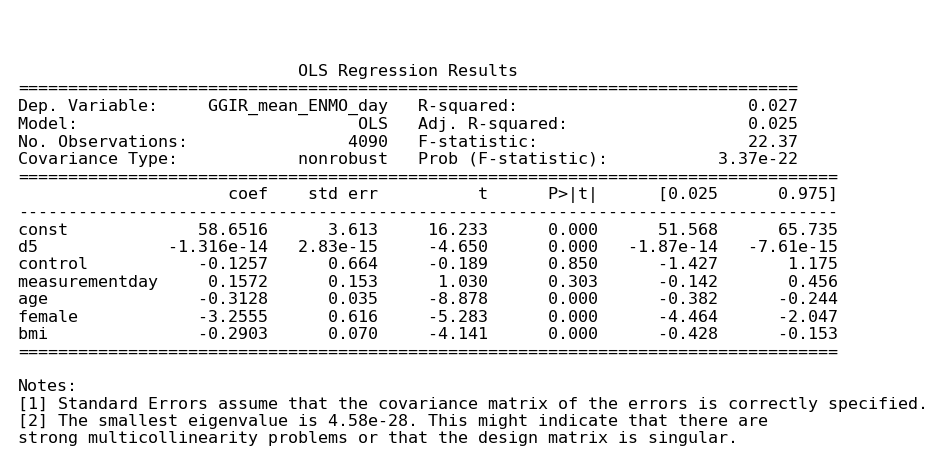

In [ ]:
XVar = df[["d5", "control", "measurementday", "age", "female", "bmi"]] #independent
XVar1 = sm.add_constant(XVar)
model = sm.OLS(YVar, XVar1).fit()
#print(model.summary(slim=True))

plt.rc('figure', figsize=(10, 5))
plt.text(0.01, 0.05, str(model.summary(slim=True)), {'fontsize': 12}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'{dir_plots} Regression ENMO day - Hypertension&OA')

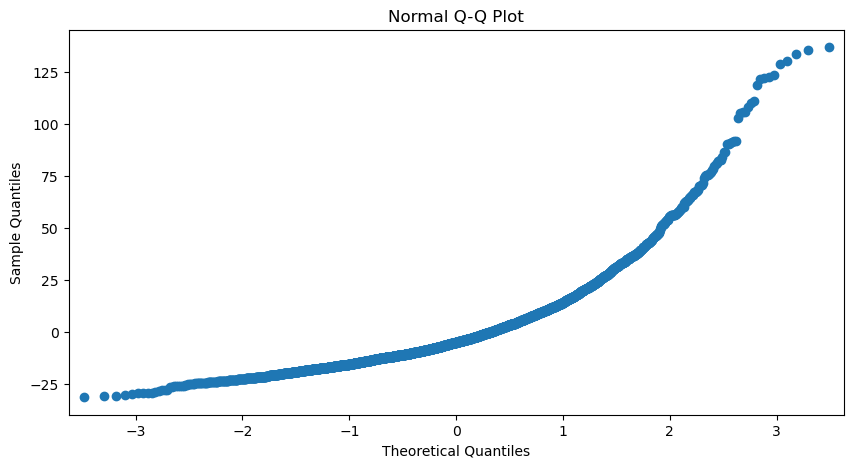

In [ ]:
residuals = model.resid
sm.qqplot(residuals)
plt.title("Normal Q-Q Plot")
plt.show()

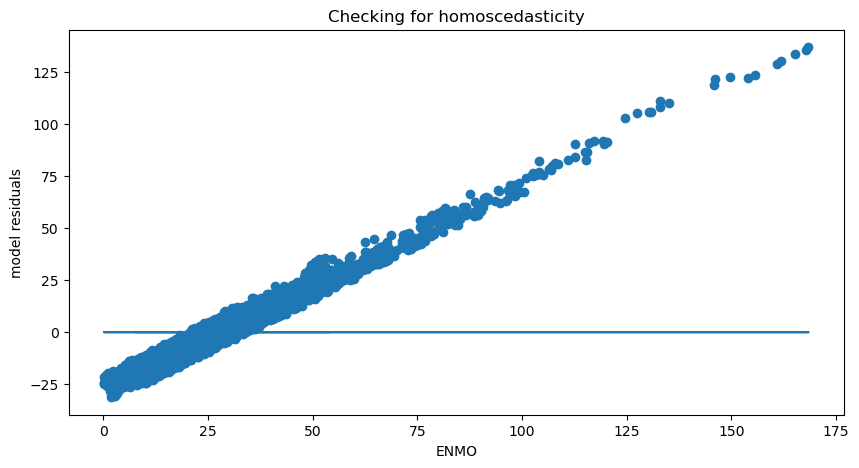

In [ ]:
plt.scatter(YVar, residuals)
plt.xlabel("ENMO")
plt.ylabel("model residuals")
plt.title("Checking for homoscedasticity")
plt.plot(YVar, [0]*len(YVar))